## Exercise 3.1
Consider the function 

\begin{align}
f\left(x\right) = \sin^{2}\left(\pi x\right) + a x^{2}
\end{align}

for $a = 0.1$ and apply a simulated annealing scheme to find the argument that provides the minimum. 

Use a geometric update scheme for the inverse temperature, i.e. $\beta_{t} = \beta_{t-1} \times r$ for several values of $r > 1$

Consider a proposal probability of the kind

\begin{align}
q\left(x^{t+1} | x^{t} \right) \sim U\left[ x^{t} - a, x^{t} + a \right] 
\end{align}

for $a = 0.2$

In [61]:
# Define the function
f(x; a = 0.2) = sin.(π .* x) .^ 2 .+ a .* x .^ 2

f (generic function with 1 method)

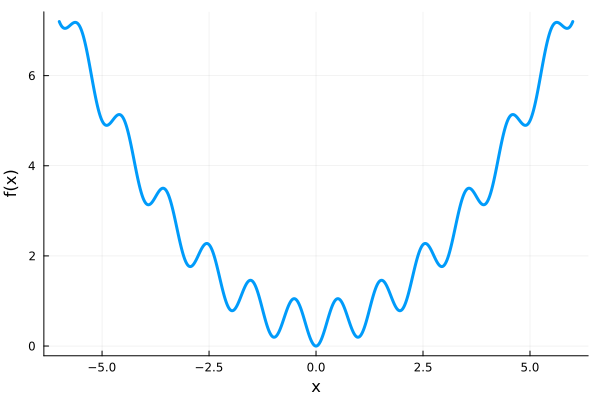

In [62]:
using Plots

xlin = -6:0.001:6

minf = minimum(f(xlin))
argminf = xlin[argmin(f(xlin))]
plot(xlin, f(xlin), xlabel = "x", ylabel = "f(x)", leg = false, linewidth = 3.0)

In [63]:
# Initial condition
#x = -6 + rand()*12
x = 5.0
# SA parameters
β = 0.1 # high temperature
βinf = 100 #final temperature
# Try to modify r
r = 1.00001 # 1.01 1.001 1.0001 1.00001
# MH parameters
a = 0.2

# Collect results in these structures
β_all = [β]
x_all = [x]
f_all = [f(x)]
πβ = []
βp = []
iter = 0
itermax = ceil(Int, log(βinf/β)/log(r))
while β < βinf

    # Metropolis-Hasting step with proposal probability q(x^t+1 | x^t) \sim U(x^t - a, x^t + a)
    newx = x - a + rand() * (2 * a)
    acc = exp(-β * (f(newx) - f(x))) #the proposal is symmetric, hence the two terms at numerator and denominator cancel
    if rand() < acc
        x = newx
    end
    push!(x_all, x)
    push!(β_all, β)
    push!(f_all, f(x))
    if mod(iter, ceil(Int,itermax/10)) == 0
        push!(βp, round(β, digits=2))  
        push!(πβ, exp.(-β * f(xlin)))
    end
    iter = iter + 1
    β *= r
end
# Auxiliary data for plotting (avoiding memory crash)
npoints = length(x_all)
to_plot = 200
dt = ceil(Int64, npoints / to_plot)
@show f(x), x


(f(x), x) = (0.0009198364259429684, 0.009559013599072463)


(0.0009198364259429684, 0.009559013599072463)

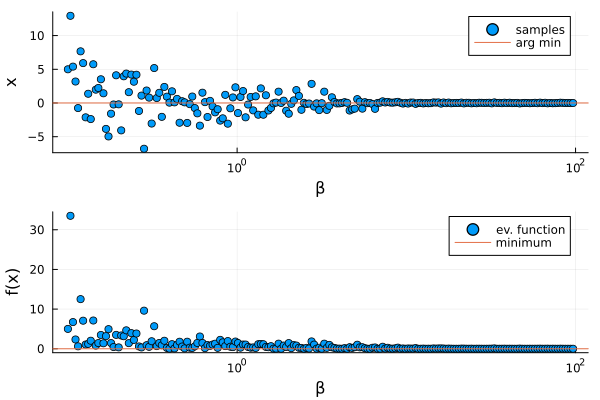

In [64]:
p1 = scatter(β_all[1:dt:end], x_all[1:dt:end], xscale = :log10, xlabel = "β", ylabel = "x", label = "samples")
p1 = hline!([argminf], label = "arg min", legend = :best)
p2 = scatter(β_all[1:dt:end], f_all[1:dt:end], xscale = :log10, xlabel = "β", ylabel = "f(x)", label = "ev. function")
p2 = hline!([minf], label = "minimum")

plot(p1, p2, layout = (2, 1))

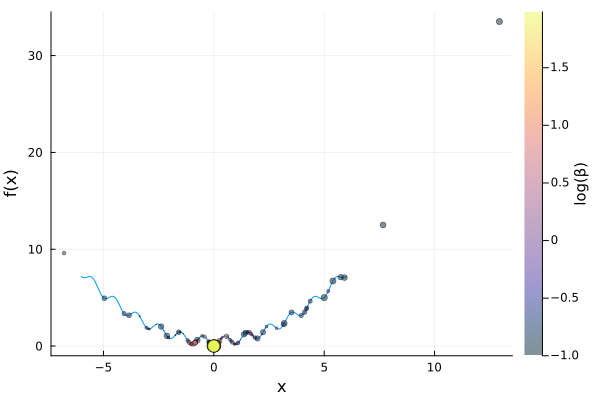

In [65]:
p5 = plot(xlin, f(xlin), xlabel = "x", ylabel = "f(x)", leg = false, linewitdh = 3.0)
p5 = scatter!(x_all[1:dt:end], f_all[1:dt:end], marker_z = log10.(β_all[1:dt:end]), markersize = 1.5 * log.(β_all[1:dt:end]),
    color = :thermal, alpha = 0.5, colorbar = true, colorbar_title = "log(β)")
plot(p5)


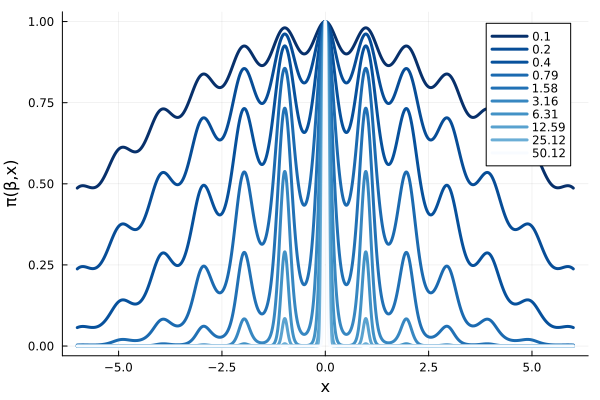

In [66]:
using ColorSchemes
cmp = cgrad(:Blues_9, length(πβ), rev = true)
p0 = plot(xlin,  πβ[1], color = cmp[1], label = βp[1], linewidth = 3.0)
for i in 2:length(πβ)-1
    p0 = plot!(xlin, πβ[i], color = cmp[i], label = βp[i], linewidth = 3.0)
end
p0 = plot!(xlin, πβ[end], color = cmp[end], label = βp[end], linewidth = 3.0)
plot(p0, xlabel = "x", ylabel = "π(β,x)" )

## The knapsack problem
This combinatorial optimization problem consists of finding the best way of filling a backpack that can carry a maximum weight $\mathcal{W}$. 

The available items are $N$ and each of them has a different value and a different weight. The idea is to bring as many items as possible, maximizing their values (soft constrain) without exceeding the maximum weight (hard constraint). 

Mathematically, we can call $\boldsymbol{x} \in \{0,1\}^{N}$ a vector associated with the full set of items. For $x_{i} = 1$ the $i^{\mathrm th}$ item is taken, for $x_{i} = 0$ the $i^{\mathrm th}$ item is discarded. Suppose that each item $i$ has a value $v_{i} \in \mathbb{R}^{+}$ and a weight $w_{i} \in \mathbb{R}^{+}$. For a given configuration $\boldsymbol{x}$, the total carried value and weight are given by

\begin{align}
V\left( \boldsymbol{x}\right) = \sum_{i} x_{i} v_{i}, \qquad
W\left( \boldsymbol{x}\right) = \sum_{i} x_{i} w_{i}
\end{align}

respectively. The problem can be formulated as 

\begin{align}
\boldsymbol{x}^{\mathrm opt} = \argmax_{\boldsymbol{x}: W\left(\boldsymbol{x}\right) \leq \mathcal{W}}  V\left( \boldsymbol{x}\right)
\end{align}



### Dynamic programming solution

Let us define a table $T\left(i, w\right)$ for $i = 0,\ldots, N$ and $w = 0, \ldots, \mathcal{W}$. The value stored in $T\left(i,w\right)$ corresponds to the total available value when at most the first $i^{th}$ elements are taken and having at most a total weight of $w$.

If we are able to compute this table (and to keep track of the best configuration), the value in $T\left(N, \mathcal{W}\right)$ will provide the solution to our problem.

#### Rules

The table entries must satisfy the following relations:
- For $i = 0$ no items are considered ad therefore no weight is associated with this case, $T\left(0,w\right) = 0$ for $w  = 0,\ldots,\mathcal{W}$
- The entry $T\left(i,w\right)$ is determined choosing the best option between the two possible conditions: 
   
    \begin{align}
    T\left(i,w\right)\ = \max\{T\left(i-1,w\right), v_{i} + T\left(i-1, w-w_{i}\right)\}
    \end{align}
    
    - The first member corresponds to the case where $i$ is not added to the list (the total weight was $w$ for $i-1$ items and stay $w$ when considering the first $i^{\mathrm th} $ items). 
    - In the second case the $i^{\mathrm th}$ item is taken: the entry $T\left(i,w\right)$ is obtained by adding $v_{i}$ to the value gained by the previous $i-1$; note that, in this case, to have a total weight $w$ for $i$ items, the total weight for $i-1$ items must be at most $w-w_{i}$ (indeed this is possible only for $w$ such that $w_{i} \leq w$). 
- The get access to the best configuration we need to keep track of whether an item is taken or not while filling the table. To this end we can define $K\left(i,w\right)$ which entries are $1$ only if $i$ has been considered in $T\left(i,w\right)$.


#### Advantage and bottleneck
- (+) It converges to the optimal solution
- (-) It takes $O\left(N\mathcal{W}\right)$ operations 

In [67]:
# Create an instance
N = 10
W = 20
v = [rand(1:10) for i in 1:N]
w = [rand(1:20) for i in 1:N]
[v, w]

2-element Vector{Vector{Int64}}:
 [1, 8, 2, 2, 7, 7, 4, 1, 10, 4]
 [15, 16, 11, 12, 5, 15, 12, 1, 6, 10]

In [68]:
using OffsetArrays # to get 0 index

function knapsack(W, v, w)
    N = length(v)
    # Initialization
    T = OffsetArrays.OffsetArray(zeros(Int64, N + 1, W + 1), 0:N, 0:W)
    K = OffsetArrays.OffsetArray(zeros(Int64, N + 1, W + 1), 0:N, 0:W)
    x_opt = zeros(Int64, N)
    # Filling the table value (in alternative, it can be done recursively) bottom-up
    for i in 1:N
        for wj in 0:W
            if w[i] <= wj # Check if wj is sufficiently large
                if v[i] + T[i-1, wj-w[i]] > T[i-1, wj]
                    T[i, wj] = v[i] + T[i-1, wj-w[i]]
                    K[i, wj] = 1 # Keep track of the added items
                else
                    T[i, wj] = T[i-1, wj]
                end
            else
                T[i, wj] = T[i-1, wj]
            end
        end
    end

    # Get the best configuration as x^opt
    Wj = W
    for i in N:-1:1
        if K[i, Wj] == 1
            x_opt[i] = 1
            Wj -= w[i]
        end
    end

    return T, K, x_opt

end

knapsack (generic function with 1 method)

In [69]:
@time T, K, x_opt = knapsack(W, v, w);
display(T)

11×21 OffsetArray(::Matrix{Int64}, 0:10, 0:20) with eltype Int64 with indices 0:10×0:20:
 0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1
 0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   1   8   8   8   8   8
 0  0  0  0  0  0   0   0   0   0   0   2   2   2   2   2   8   8   8   8   8
 0  0  0  0  0  0   0   0   0   0   0   2   2   2   2   2   8   8   8   8   8
 0  0  0  0  0  7   7   7   7   7   7   7   7   7   7   7   9   9   9   9   9
 0  0  0  0  0  7   7   7   7   7   7   7   7   7   7   7   9   9   9   9  14
 0  0  0  0  0  7   7   7   7   7   7   7   7   7   7   7   9  11  11  11  14
 0  1  1  1  1  7   8   8   8   8   8   8   8   8   8   8   9  11  12  12  14
 0  1  1  1  1  7  10  11  11  11  11  17  18  18  18  18  18  18  18  18  18
 0  1  1  1  1  7  10  11  11  11  11  17  18  18  18  18  18  18  18  18  18

  0.069146 seconds (161.60 k allocations: 7.665 MiB, 99.95% compilation time)


In [70]:
display(K)

11×21 OffsetArray(::Matrix{Int64}, 0:10, 0:20) with eltype Int64 with indices 0:10×0:20:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0
 0  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  0  0  1  1  0
 0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [71]:
# Output the solution 
println("Best items to store: ", findall(x_opt .== 1), ". V(x_opt) = ", x_opt' * v, ", W(x_opt) = ", x_opt' * w, " <= ", W)


Best items to store: [5, 8, 9]. V(x_opt) = 18, W(x_opt) = 12 <= 20


### Simulated annealing 

We can use a Metropolis-Hastings algorithm (paired to a simulated annealing scheme) to sample feasible solutions (i.e. with corresponding not exceeding weight) that maximize the value. We would like to sample

\begin{align}
\pi_{\beta} \left( \boldsymbol{x} \right) \propto e^{\beta V\left(\boldsymbol{x} \right)} \mathbb{I} \left[ W\left( \boldsymbol{x} \right) \leq \mathcal{W} \right] \quad \beta \rightarrow +\infty 
\end{align}

Use: 
- A proposal probability $q\left(\boldsymbol{x}^{t} | \boldsymbol{x}^{t-1} \right) = \left[\mathbb{I} \left[x_{i}^{t} = 0\right] \delta_{x_{i}^{t-1},1} + \mathbb{I} \left[ x^{t}_{i} = 1 \right] \delta_{x_{i}^{t-1},0} \right] \prod_{j\neq i} \delta_{x^{t}_{j}, x^{t-1}_{j}} $ where $i$ is uniformly chosen in $1,\ldots,N$
So basically we choose uniformly randomly an index and swap it wrt the preceding configuration, then we check whether the configuration is feasible and in that case we compute the acceptance ratio.
- A geometric update scheme for small $r$

Note that many configurations not satisfying the hard constraint will be rejected

In [72]:
V_function(x) = sum(x.*v)
W_function(x) = sum(x.*w)

# Initial condition
#x = -6 + rand()*12
x = zeros(N)
# SA parameters
β = 0.1 # high temperature
βinf = 1000 #final temperature
# Try to modify r
r = 1.0001 # 1.01 1.001 1.0001 1.00001

# Collect results in these structures
β_all = [β]
x_all = [x]
f_all = [V_function(x)]
iter = 0
itermax = ceil(Int, log(βinf/β)/log(r))
while β < βinf
    
    u=rand()
    i=0
    for j=1:N
        if u<j/N
            i=j
            break
        end
    end

    x_trial=x
    x_trial[i]=1-x_trial[i]

    if(W_function(x_trial)<=W)
        acc = exp(-β * (V_function(x_trial) - V_function(x)))
        if rand() < acc
            x = x_trial
        end
        push!(x_all, x)
        push!(β_all, β)
        push!(f_all, V_function(x))
        iter = iter + 1
        β *= r
    end
end
@show V_function(x), x


(V_function(x), x) = (12.0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])


(12.0, [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0])

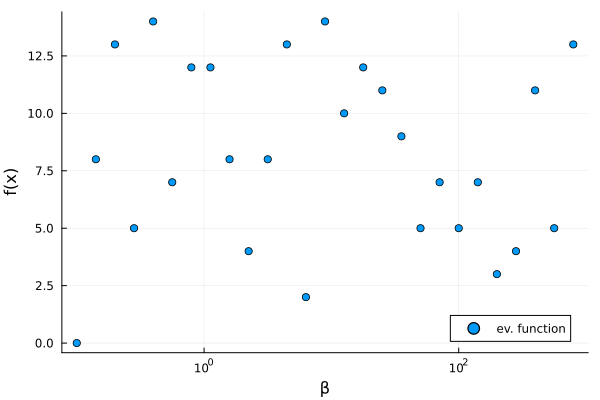

In [73]:
scatter(β_all[1:dt:end], f_all[1:dt:end], xscale = :log10, xlabel = "β", ylabel = "f(x)", label = "ev. function")

In [74]:
# Output the solution 
println("Best items to store: ", findall(x .== 1), ". V(x_opt) = ", x' * v, ", W(x_opt) = ", x' * w, " <= ", W)


Best items to store: [4, 9]. V(x_opt) = 12.0, W(x_opt) = 18.0 <= 20
